# xgboost mini-project for Yazabi/SharpestMinds
- Author: Chris Hodapp
- Date: 2017-11-09
- Dataset: [Wisconsin Diagnostic Breast Cancer (WDBC)](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names)
- To read:
  - [A Guide to Gradient Boosted Trees with XGBoost in Python](https://jessesw.com/XG-Boost/)
  - [XGBoost: A Scalable Tree Boosting System](https://arxiv.org/pdf/1603.02754v1.pdf)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.externals
import sklearn.manifold
import sklearn.model_selection
import xgboost

import train_and_test

/nix/store/11gkg09dzkvamnfiygipz78m2gjvxrz6-python3-3.5.4-env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Just for testing:
import importlib
train_and_test = importlib.reload(train_and_test)

In [3]:
train_raw = train_and_test.read_data("data/train_data.txt")
test_raw = train_and_test.read_data("data/test_data.txt")
both = pd.concat((train_raw, test_raw))

- The description said no data is missing and it appears to be right:

In [4]:
both.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 0 to 113
Data columns (total 32 columns):
ID                    569 non-null int64
diag                  569 non-null object
radius                569 non-null float64
texture               569 non-null float64
perimeter             569 non-null float64
area                  569 non-null float64
smoothness            569 non-null float64
compactness           569 non-null float64
concavity             569 non-null float64
concave_points        569 non-null float64
symmetry              569 non-null float64
fractal_dim           569 non-null float64
radius_std            569 non-null float64
texture_std           569 non-null float64
perimeter_std         569 non-null float64
area_std              569 non-null float64
smoothness_std        569 non-null float64
compactness_std       569 non-null float64
concavity_std         569 non-null float64
concave_points_std    569 non-null float64
symmetry_std          569 non-null flo

In [5]:
both[["diag"]].groupby("diag").size()

diag
B    357
M    212
dtype: int64

In [6]:
train_raw.iloc[:20,:]

,ID,diag,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,...,radius_w,texture_w,perimeter_w,area_w,smoothness_w,compactness_w,concavity_w,concave_points_w,symmetry_w,fractal_dim_w
0,915940,B,14.580,13.66,94.29,658.8,0.09832,0.08918,0.082220,0.043490,...,16.76,17.24,108.50,862.0,0.12230,0.19280,0.249200,0.09186,0.2626,0.07048
1,904969,B,12.340,14.95,78.29,469.1,0.08682,0.04571,0.021090,0.020540,...,13.18,16.85,84.11,533.1,0.10480,0.06744,0.049210,0.04793,0.2298,0.05974
2,88466802,B,10.650,25.22,68.01,347.0,0.09657,0.07234,0.023790,0.016150,...,12.25,35.19,77.98,455.7,0.14990,0.13980,0.112500,0.06136,0.3409,0.08147
3,843786,M,12.450,15.70,82.57,477.1,0.12780,0.17000,0.157800,0.080890,...,15.47,23.75,103.40,741.6,0.17910,0.52490,0.535500,0.17410,0.3985,0.12440
4,903811,B,14.060,17.18,89.75,609.1,0.08045,0.05361,0.026810,0.032510,...,14.92,25.34,96.42,684.5,0.10660,0.12310,0.084600,0.07911,0.2523,0.06609
5,88350402,B,13.640,15.60,87.38,575.3,0.09423,0.06630,0.047050,0.037310,...,14.85,19.05,94.11,683.4,0.12780,0.12910,0.153300,0.09222,0.2530,0.06510
6,891703,B,11.850,17.46,75.54,432.7,0.08372,0.05642,0.026880,0.022800,...,13.06,25.75,84.35,517.8,0.13690,0.17580,0.131600,0.09140,0.3101,0.07007
7,871642,B,10.660,15.15,67.49,349.6,0.08792,0.04302,0.000000,0.000000,...,11.54,19.20,73.20,408.3,0.10760,0.06791,0.000000,0.00000,0.2710,0.06164
8,8911230,B,11.330,14.16,71.79,396.6,0.09379,0.03872,0.001487,0.003333,...,12.20,18.99,77.37,458.0,0.12590,0.07348,0.004955,0.01111,0.2758,0.06386
9,8912049,M,19.160,26.60,126.20,1138.0,0.10200,0.14530,0.192100,0.096640,...,23.72,35.90,159.80,1724.0,0.17820,0.38410,0.575400,0.18720,0.3258,0.09720


In [7]:
# Verify that all IDs are unique (and we can just ignore them):
len(both.ID), len(both.ID.unique())

(569, 569)

# t-SNE
- With lower perplexity values, seems to show some clear clustering.

In [8]:
train_X, train_y, test_X, test_y = train_and_test.get_processed_data()

In [9]:
tsne = sklearn.manifold.TSNE(
    n_components=2, perplexity=10, random_state=100)
embed = tsne.fit_transform(train_X)

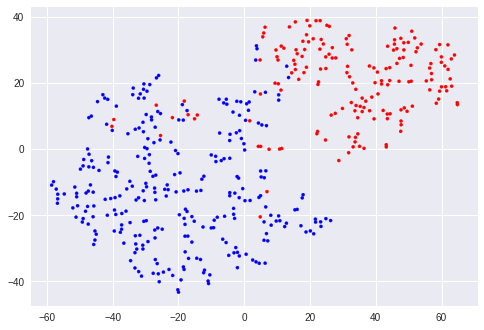

In [10]:
plt.scatter(
    embed[:,0], embed[:,1], s=10,
    c=list("r" if c else "b" for c in train_y),
)
plt.show()

# Histograms & Distributions

- Most of the mean features look right-skewed to varying degrees (which I guess I'd expect some amount of when it is positive measurements which can't have tails going into the negative direction, but can have them going into the positive direction)

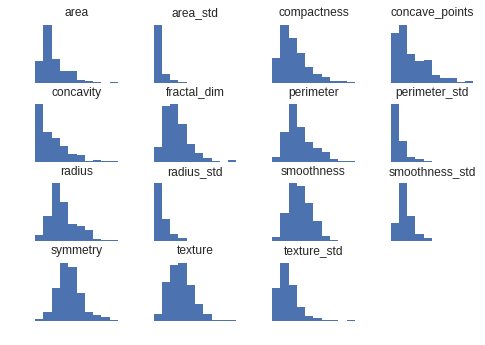

In [11]:
plots = train_X.iloc[:, 0:15].hist()
for row in plots:
    for subplot in row:
        subplot.axis('off')
plt.show()

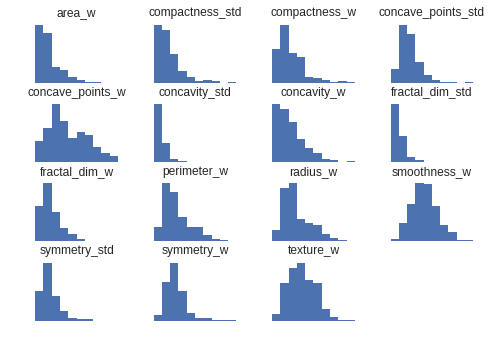

In [12]:
plots = train_X.iloc[:, 15:].hist()
for row in plots:
    for subplot in row:
        subplot.axis('off')
plt.show()

In [13]:
num_cols = ["radius", "texture", "perimeter", "area",
            "smoothness", "compactness", "concavity", "concave_points",
            "symmetry", "fractal_dim"]
X_num = train_X[num_cols]
skewness = pd.DataFrame().\
    assign(
        Feature = num_cols,
        Skewness = scipy.stats.skew(X_num),
        Kurtosis = scipy.stats.kurtosis(X_num),
        SkewTest = scipy.stats.skewtest(X_num).pvalue,
        KurtosisTest = scipy.stats.kurtosistest(X_num).pvalue,
    )
skewness[skewness.SkewTest < 0.05].sort_values("Skewness")

,Feature,Kurtosis,KurtosisTest,SkewTest,Skewness
4,smoothness,0.854484,3.608233e-03,1.560718e-06,0.581897
1,texture,0.821703,4.619562e-03,4.989483e-07,0.612930
8,symmetry,0.787852,5.956549e-03,3.760079e-07,0.620514
0,radius,0.924565,2.122621e-03,3.442927e-13,0.961502
2,perimeter,1.053051,7.986426e-04,3.780178e-14,1.012640
7,concave_points,0.975160,1.445139e-03,2.714639e-16,1.125801
5,compactness,1.569954,1.621244e-05,1.715407e-17,1.188744
9,fractal_dim,2.824175,3.115113e-09,9.195138e-20,1.307789
6,concavity,2.032427,5.809131e-07,8.459342e-22,1.414875
3,area,3.961915,4.658192e-12,4.625356e-27,1.695744


# Correlation Matrix


In [14]:
# df = dataframe
# cols = column names in said dataframe (needed for labels)
# threshold = optional threshold to force lower correlations to 0
# size = optional figure size passed to plt.figure
def plot_correlations(df, cols, threshold=0, size=None):
    # Adapted from Yazabi Python Data Preprocessing Walkthrough
    corrs = df.loc[:,cols].corr()
    if threshold > 0:
        corrs[:] = np.where(abs(corrs) < threshold, 0, corrs)
    if size:
        fig = plt.figure(figsize=size)
    else:
        fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corrs)
    #add a colorbar legend
    fig.colorbar(cax)
    #rotate the x-axis labels so they don't overlap
    ax.set_xticklabels(cols, rotation=90)
    ax.set_yticklabels(cols)
    #we have to force the plot to show us all labels, because it won't by default
    plt.xticks(np.arange(0,len(cols), 1.0))
    plt.yticks(np.arange(0,len(cols), 1.0))
    plt.show()

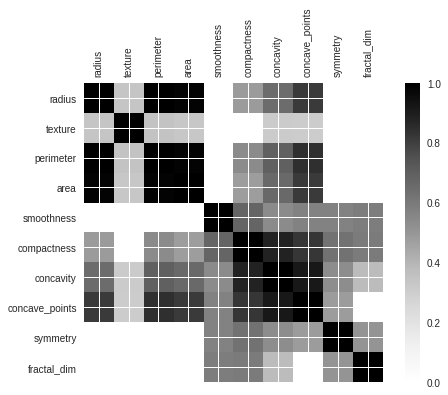

In [15]:
plot_correlations(train_X, num_cols, 0.3)

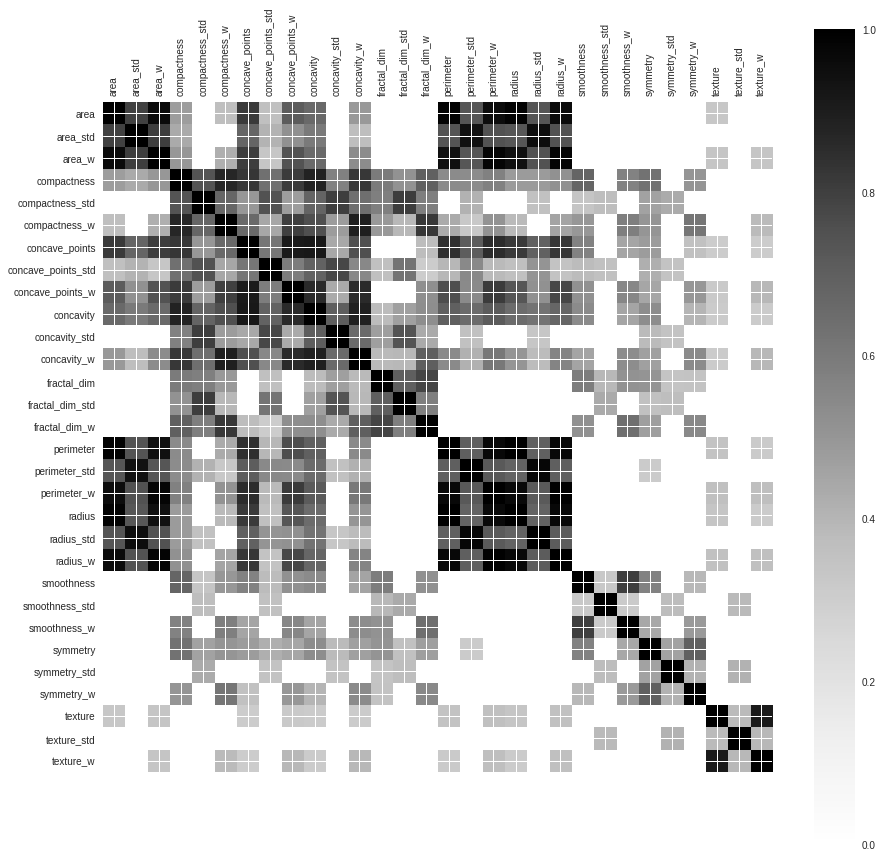

In [16]:
cols = list(train_X.columns)
cols.sort()
plot_correlations(train_X, cols, 0.3, (15,15))

- Predictably, means and worst measurements (e.g. `area` and `area_w`) tend to correlate, though some more than others, and likewise for means and standard error (e.g. `area` and `area_std`) to a lesser extent
- Intuitively, I'd expect to see that larger standard errors correspond to a wider range between mean and worst
- Perimeter, radius, and area all correlate strongly, perhaps due to encoding some redundancy
- Compactness, concavity, and concave points also correlate somewhat; these all seem to correlate somewhat with perimeter, radius, and area too
- Texture seems correlated with very little.  Smoothness, symmetry, and fractal dimension correlate with each other, and somewhat with concavity/compactness/concave points, but seemingly little else.

- Actually, re-reading the data dictionary, compactness is already defined as `(perimeter^2 / area - 1.0)`. Trying that out below, though, a relationship is clear but magnitudes and sometimes ordering are off (note that while `compactness` increases monotonically, `(perimeter^2 / area - 1.0)` does not):

In [17]:
compact = train_raw.perimeter**2 / train_raw.area - 1.0
train_raw.\
    assign(compact = compact).\
    loc[:, ["compactness", "compact"]].\
    sort_values(by=["compactness"], axis=0).\
    reset_index(drop=True)

,compactness,compact
0,0.01938,11.776672
1,0.02344,11.801572
2,0.02650,11.822802
3,0.03116,11.896669
4,0.03212,11.933599
5,0.03393,11.968588
6,0.03398,11.878935
7,0.03454,11.943558
8,0.03515,11.918608
9,0.03558,11.938469


# Model experimentation

In [18]:
# Untuned xgboost:
xgb = xgboost.XGBClassifier()
scores = sklearn.model_selection.cross_val_score(
    xgb, train_X, train_y)
print("Cross-validation accuracy: {0:.3f} ± {1:.3f}".format(
    scores.mean(), scores.std() * 2))

Cross-validation accuracy: 0.952 ± 0.023


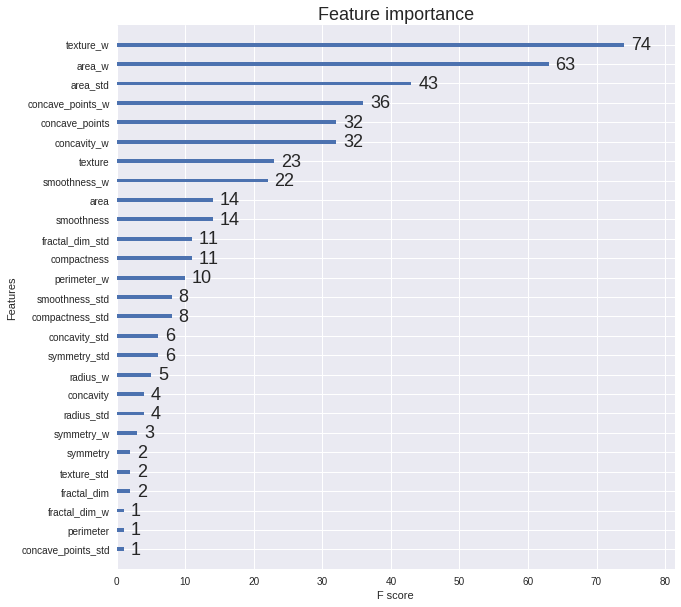

In [19]:
xgb.fit(train_X, train_y)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
sns.set(font_scale = 1.5)
xgboost.plot_importance(xgb, ax=ax)
plt.show()

## Hyperparameter tuning

In [20]:
params = {
    "max_depth": (3, 4, 5, 6, 7),
    "learning_rate": (0.05, 0.1, 0.15, 0.20),
    "n_estimators": (100, 150, 200),
    "gamma": (0.0, 0.05, 0.1, 0.15),
    "min_child_weight": (1,),
    "subsample": (0.8, 0.85, 0.9, 0.95, 1.0),
    "reg_alpha": (0, 0.05, 0.1, 0.15, 0.2),
    "reg_lambda": (1.0, 1.1, 1.2, 1.3),
}
xgb = xgboost.XGBClassifier(nthread=-1, seed=1234)
cv = sklearn.model_selection.GridSearchCV(xgb, params, cv=5)
cv.fit(train_X, train_y)
sklearn.externals.joblib.dump(cv, "xgboost_gridsearchcv3.pkl")
print("Best score: {0}".format(cv.best_score_))
print("Best params: {0}".format(cv.best_params_))

Best score: 0.9736263736263736
Best params: {'reg_alpha': 0.15, 'subsample': 0.8, 'gamma': 0.0, 'max_depth': 3, 'reg_lambda': 1.2, 'n_estimators': 150, 'learning_rate': 0.1, 'min_child_weight': 1}


In [21]:
# No particular reason to dump/load; this is just here to test it
# since the assignment requires it:
cv2 = sklearn.externals.joblib.load("xgboost_gridsearchcv3.pkl")
test_y_pred = cv2.predict(test_X)
test_acc = sklearn.metrics.accuracy_score(test_y, test_y_pred)
print("Testing accuracy: {0}".format(test_acc))

Testing accuracy: 0.9649122807017544


In [22]:
cv2.best_params_

{'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 150,
 'reg_alpha': 0.15,
 'reg_lambda': 1.2,
 'subsample': 0.8}

In [23]:
dmat = xgboost.DMatrix(train_X, train_y)
params = {
    "objective": "binary:logistic",
    "eta": cv2.best_params_["learning_rate"],
    "subsample": cv2.best_params_["subsample"],
    "max_depth": cv2.best_params_["max_depth"],
    "lambda": cv2.best_params_["reg_lambda"],
    "alpha": cv2.best_params_["reg_alpha"],
}
cv_xgb = xgboost.cv(
    params = params,
    dtrain = dmat,
    num_boost_round = 1000,
    early_stopping_rounds = 100,
    nfold = 5,
)

In [24]:
cv_xgb.tail(5)

,test-error-mean,test-error-std,train-error-mean,train-error-std
123,0.035165,0.017582,0.0,0.0
124,0.035165,0.017582,0.0,0.0
125,0.035165,0.017582,0.0,0.0
126,0.035165,0.017582,0.0,0.0
127,0.032967,0.018388,0.0,0.0


- Interesting; does this mean that, given `early_stopping_rounds`, CV error stopped improving at 27 iterations?